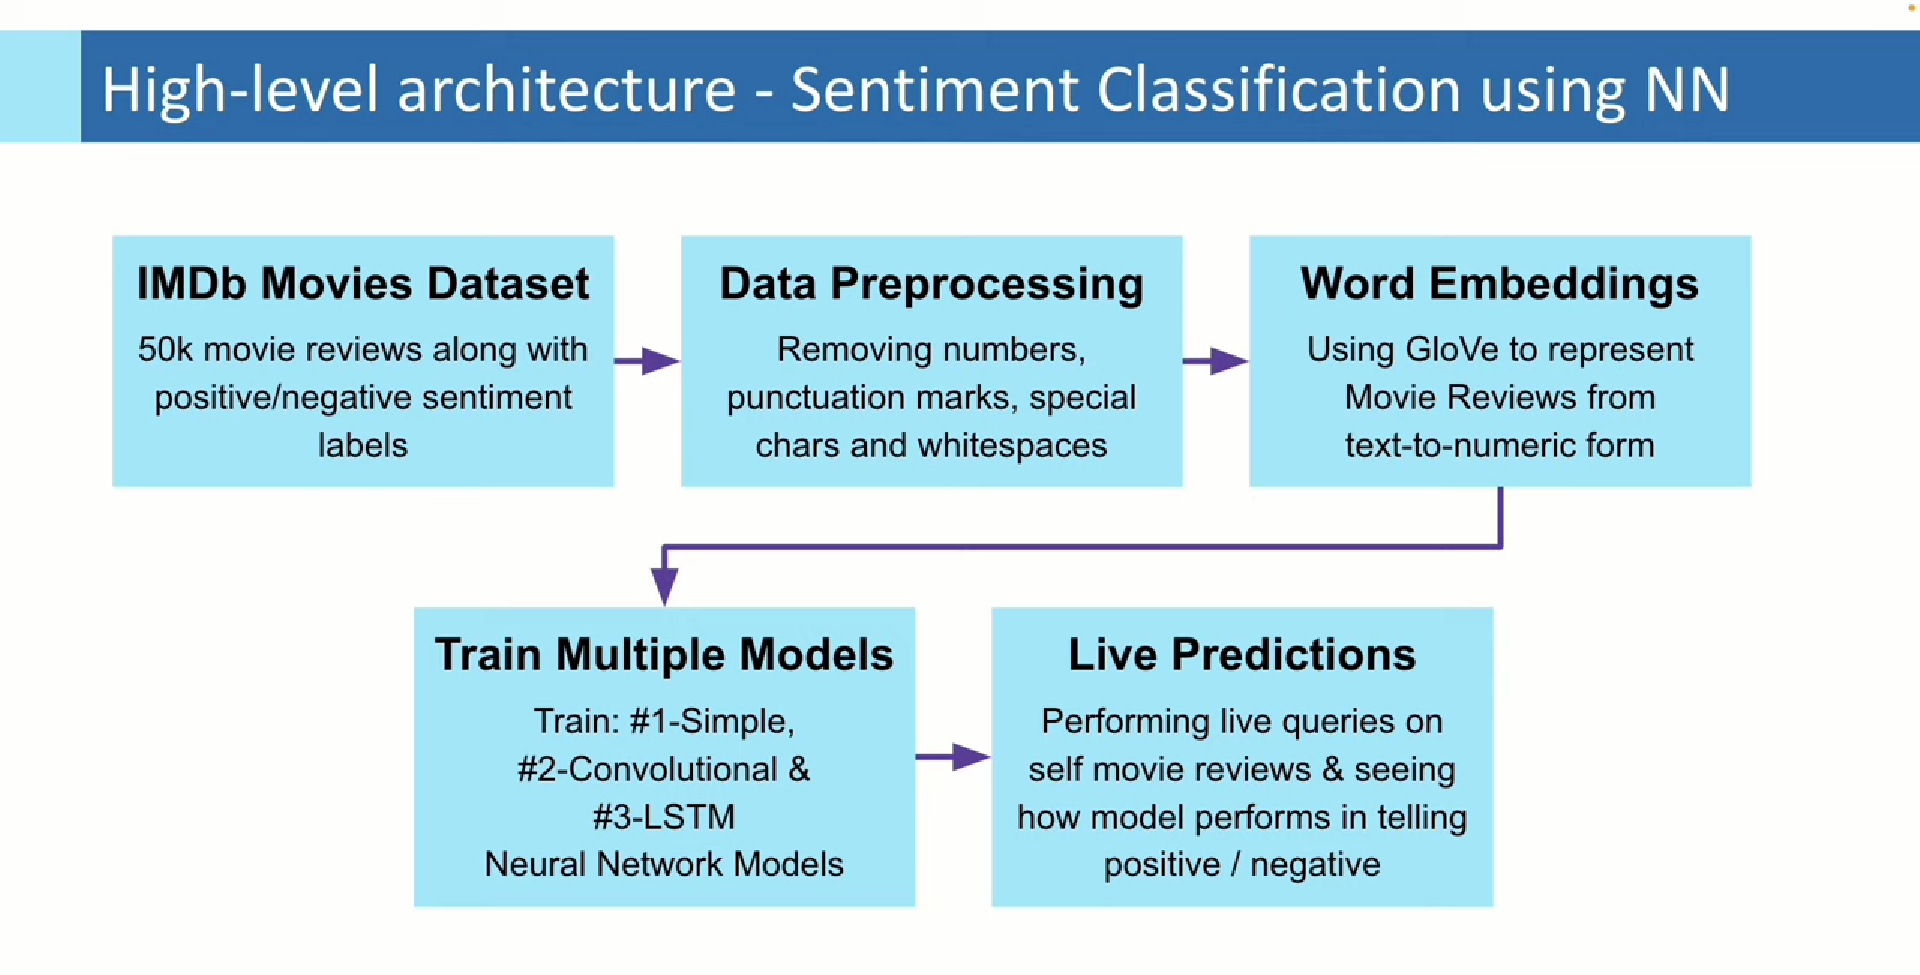

In [9]:
from IPython.display import Image

Image("file.png")


## Setting the environment

In [1]:
# # Mounting google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
## Setting toolkit folder as working directory

# %cd /content/drive/My Drive/imdb sentiment analysis
# !ls

In [1]:
# # Install the necessary libraries
# !pip install numpy pandas nltk scikit-learn
# !pip install tensorflow keras

In [2]:

# Importing essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split


In [20]:
from keras_preprocessing.sequence import pad_sequences

In [ ]:
# Download NLTK data
nltk.download('stopwords')


## Loading dataset

In [7]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [8]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [9]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<AxesSubplot:xlabel='sentiment', ylabel='count'>

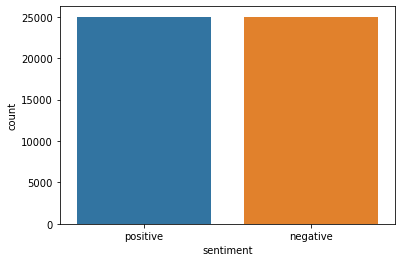

In [11]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [12]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [9]:
# import b2_preprocessing_function
from b2_preprocessing_function import CustomPreprocess

In [10]:
custom = CustomPreprocess()
custom.preprocess_text("Those were the best days of my life!")

'best days life '

In [15]:
# TAG_RE = re.compile(r'<[^>]+>')

# def remove_tags(text):
#     '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

#     return TAG_RE.sub('', text)

In [16]:
# import nltk
# nltk.download('stopwords')

In [17]:
# def preprocess_text(sen):
#     '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
#     in lowercase'''
    
#     sentence = sen.lower()

#     # Remove html tags
#     sentence = remove_tags(sentence)

#     # Remove punctuations and numbers
#     sentence = re.sub('[^a-zA-Z]', ' ', sentence)

#     # Single character removal
#     sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

#     # Remove multiple spaces
#     sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

#     # Remove Stopwords
#     pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
#     sentence = pattern.sub('', sentence)

#     return sentence

In [18]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(custom.preprocess_text(sen))

In [19]:
# Sample cleaned up movie review 

X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [20]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [22]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [15]:
import io
import json

In [24]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [25]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [26]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [27]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [28]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [29]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## Simple Neural Network

In [25]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [26]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,249,401
Trainable params: 10,001
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [27]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 4s 10ms/step - loss: 0.5548 - acc: 0.7180 - val_loss: 0.5057 - val_acc: 0.7576
Epoch 2/6
250/250 [==============================] - 3s 13ms/step - loss: 0.4483 - acc: 0.7955 - val_loss: 0.4928 - val_acc: 0.7640
Epoch 3/6
250/250 [==============================] - 3s 13ms/step - loss: 0.4119 - acc: 0.8148 - val_loss: 0.4998 - val_acc: 0.7654
Epoch 4/6
250/250 [==============================] - 4s 15ms/step - loss: 0.3891 - acc: 0.8299 - val_loss: 0.5101 - val_acc: 0.7595
Epoch 5/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3753 - acc: 0.8362 - val_loss: 0.5349 - val_acc: 0.7558
Epoch 6/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3646 - acc: 0.8418 - val_loss: 0.5354 - val_acc: 0.7544


In [ ]:
# # Model training

# snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 6ms/step - loss: 0.5589 - acc: 0.7134 - val_loss: 0.5088 - val_acc: 0.7565
Epoch 2/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4514 - acc: 0.7925 - val_loss: 0.5067 - val_acc: 0.7580
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4159 - acc: 0.8130 - val_loss: 0.5002 - val_acc: 0.7646
Epoch 4/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3918 - acc: 0.8273 - val_loss: 0.5084 - val_acc: 0.7615
Epoch 5/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3753 - acc: 0.8370 - val_loss: 0.5188 - val_acc: 0.7584
Epoch 6/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3624 - acc: 0.8435 - val_loss: 0.5325 - val_acc: 0.7558


In [28]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 0.5696 - acc: 0.7461


In [29]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5695900917053223
Test Accuracy: 0.7461000084877014


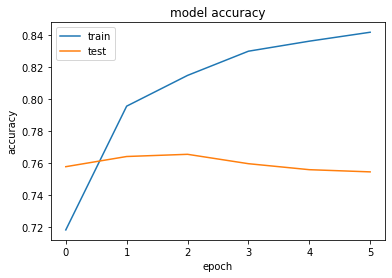

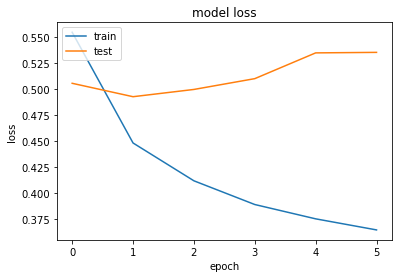

In [30]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [31]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 27s 105ms/step - loss: 0.4672 - acc: 0.7751 - val_loss: 0.3811 - val_acc: 0.8301
Epoch 2/6
250/250 [==============================] - 23s 92ms/step - loss: 0.3370 - acc: 0.8546 - val_loss: 0.3480 - val_acc: 0.8480
Epoch 3/6
250/250 [==============================] - 23s 93ms/step - loss: 0.2814 - acc: 0.8874 - val_loss: 0.3426 - val_acc: 0.8481
Epoch 4/6
250/250 [==============================] - 23s 93ms/step - loss: 0.2364 - acc: 0.9126 - val_loss: 0.3339 - val_acc: 0.8512
Epoch 5/6
250/250 [==============================] - 23s 93ms/step - loss: 0.1946 - acc: 0.9353 - val_loss: 0.3325 - val_acc: 0.8530
Epoch 6/6
250/250 [==============================] - 23s 92ms/step - loss: 0.1596 - acc: 0.9536 - val_loss: 0.3386 - val_acc: 0.8528


In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 3s 11ms/step - loss: 0.3357 - acc: 0.8579


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3356787860393524
Test Accuracy: 0.8579000234603882


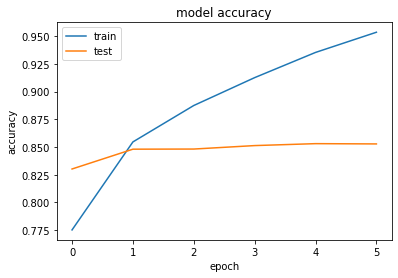

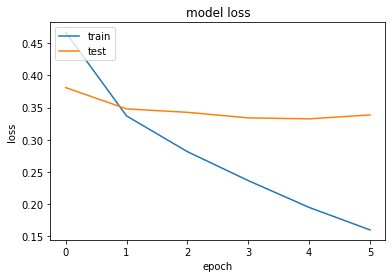

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 82s 320ms/step - loss: 0.5498 - acc: 0.7266 - val_loss: 0.4619 - val_acc: 0.7909
Epoch 2/6
250/250 [==============================] - 79s 317ms/step - loss: 0.4309 - acc: 0.8056 - val_loss: 0.4138 - val_acc: 0.8207
Epoch 3/6
250/250 [==============================] - 80s 319ms/step - loss: 0.3883 - acc: 0.8302 - val_loss: 0.3593 - val_acc: 0.8457
Epoch 4/6
250/250 [==============================] - 80s 318ms/step - loss: 0.3506 - acc: 0.8489 - val_loss: 0.3402 - val_acc: 0.8564
Epoch 5/6
250/250 [==============================] - 79s 317ms/step - loss: 0.3259 - acc: 0.8621 - val_loss: 0.3239 - val_acc: 0.8585
Epoch 6/6
250/250 [==============================] - 79s 317ms/step - loss: 0.3067 - acc: 0.8712 - val_loss: 0.3148 - val_acc: 0.8670


In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 11s 34ms/step - loss: 0.3194 - acc: 0.8643


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.31936636567115784
Test Accuracy: 0.864300012588501


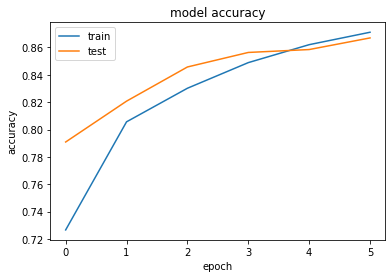

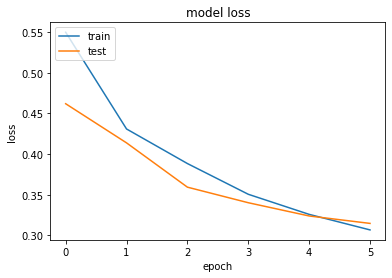

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [6]:
# # Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [7]:
pwd # lists files in working directory

'C:\\Users\\manur\\imdb sentiment analysis\\sentiment-analysis-with-deep-neural-networks-main'

In [3]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='c1_lstm_model_acc_0.864.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.
pretrained_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________


In [7]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [11]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = custom.preprocess_text(review)
  unseen_processed.append(review)

In [12]:
unseen_processed

['intelligent movie movie obviously allegorical fascinating tale ai mainly manipulation power wanting action spectacular cgi movie aimed people like think rather passively wait entertained themes ai also surveillance excellent points data us collected phone companies search engine companies commercial operating systems makers plot seems simple extremely clever protagonist playing games trying stay one step ahead one another movie perfectly consistent internal logic plays perfectly go expecting much however see people satisfied movie sets brilliantly therefore give least recent movies getting movie succeeds another recent movie ai transcendence think called failed interesting failure third movie ai spanish movie called eva also brilliant eva moving movie philosophical movies perfect different ways ai name movie ava seems nod title spanish movie aside nice stars appeared ex machina eva casting great course several aspects movie unrealistic often absurd allegorical movie acceptable movie 

In [13]:
from keras_preprocessing.text import tokenizer_from_json

In [16]:
# Loading
with open('b3_tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [17]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)

In [18]:
unseen_tokenized

[[925,
  1,
  1,
  400,
  14420,
  1289,
  627,
  14035,
  1266,
  7357,
  511,
  1524,
  97,
  1863,
  1370,
  1,
  3416,
  16,
  4,
  25,
  140,
  20211,
  716,
  2161,
  1270,
  14035,
  18,
  12177,
  199,
  659,
  9047,
  76,
  9587,
  1378,
  4780,
  1464,
  6932,
  4780,
  2013,
  7929,
  7741,
  1034,
  33,
  83,
  463,
  435,
  879,
  1740,
  282,
  1469,
  150,
  626,
  3,
  1434,
  1291,
  3,
  62,
  1,
  806,
  4114,
  5415,
  1989,
  191,
  806,
  51,
  854,
  13,
  88,
  11,
  16,
  4012,
  1,
  589,
  1958,
  1398,
  93,
  113,
  1014,
  24,
  270,
  1,
  2759,
  62,
  1014,
  1,
  14035,
  25602,
  25,
  315,
  1064,
  115,
  1852,
  736,
  1,
  14035,
  1776,
  1,
  315,
  3822,
  18,
  383,
  3822,
  569,
  1,
  4051,
  24,
  284,
  164,
  624,
  14035,
  261,
  1,
  12806,
  83,
  5440,
  294,
  1776,
  1,
  1011,
  213,
  278,
  1374,
  1040,
  14943,
  3822,
  897,
  17,
  151,
  312,
  1264,
  1,
  1928,
  285,
  1602,
  14420,
  1,
  3172,
  1,
  122,
  659,
  14

In [21]:
# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [22]:
unseen_padded

array([[  879,  1740,   282,  1469,   150,   626,     3,  1434,  1291,
            3,    62,     1,   806,  4114,  5415,  1989,   191,   806,
           51,   854,    13,    88,    11,    16,  4012,     1,   589,
         1958,  1398,    93,   113,  1014,    24,   270,     1,  2759,
           62,  1014,     1, 14035, 25602,    25,   315,  1064,   115,
         1852,   736,     1, 14035,  1776,     1,   315,  3822,    18,
          383,  3822,   569,     1,  4051,    24,   284,   164,   624,
        14035,   261,     1, 12806,    83,  5440,   294,  1776,     1,
         1011,   213,   278,  1374,  1040, 14943,  3822,   897,    17,
          151,   312,  1264,     1,  1928,   285,  1602, 14420,     1,
         3172,     1,   122,   659,   140, 13082,  1645, 10209,  1615,
          937],
       [  121,   234,   352,  8844,  6752,   630,    20,  6507,    72,
         1400,  6730,  2885, 24074, 10547,  3633,  1645,    25, 11701,
         1335, 19425,    26,   281,  1574,  1143,   288, 1370

In [23]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 1s/step


array([[0.8834934 ],
       [0.99290115],
       [0.31473464],
       [0.27548054],
       [0.97470117],
       [0.04180601]], dtype=float32)

In [24]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,3.1
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,2.8
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.4


In [25]:
unseen_sentiments

array([[0.8834934 ],
       [0.99290115],
       [0.31473464],
       [0.27548054],
       [0.97470117],
       [0.04180601]], dtype=float32)

In [28]:
unseen_sentiments[0][0]

0.8834934

In [41]:
prediction_text= f"Positive Review with probable IMDb rating as: {np.round(unseen_sentiments[0][0]*10,1)}"

In [42]:
prediction_text

'Positive Review with probable IMDb rating as: 8.8'